# 01ZLMA - Exercise 10
Exercise 10 of the course 01ZLMA. 

## Contents

* Log-linear models with Poisson distributed data
* Example from the Lecture 10 (Section 7.7. from lecture notes)



## Poission regression

Poission regression is good for modeling random variables expressing the number of occurs of independent events in given time period.  
It also proves to be more suitable for binomial data if the number of repetitions is large and the probability of success low.


*   $Y_1, \ldots, Y_n$ $iid$ $Y_i \sim Po(\mu_i)$, where $\mu_i = s_i λ_i$ and $s_i$ is known sample size.
*   Canonical link function $g(x) = ln(x)$: $\eta_i = g(\mu_i) = ln(\mu_i) = ln(s_i) + ln(\lambda_i) = ln(s_i) + x_i^T \beta$, where $i= 1,\ldots, n$ and $\mu_i = E[Y_i] = s_i\lambda_i = s_i e^{x_i^T \beta}$.




Let us assume exercise 7.7 from lecture notes (Dobson 9.2.1) - British doctors' smoking and coronary death. (https://reneues.files.wordpress.com/2010/01/an-introduction-to-generalized-linear-models-second-edition-dobson.pdf)

Data from the famous doctors study of smoking conducted by Sir Richard Doll and colleagues.

---



In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.regressionplots import plot_partregress_grid
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

In [ ]:
# import dataset
url = "https://raw.githubusercontent.com/francji1/01ZLMA/main/data/smoke.csv"
data_poiss = pd.read_csv(url, sep = ';', header=[0])
data_poiss

,age_group,deaths,person_years,smoke
0,35 to 44,32,52407,1
1,45 to 54,104,43248,1
2,55 to 64,206,28612,1
3,65 to 74,186,12663,1
4,75 to 84,102,5317,1
5,35 to 44,2,18790,0
6,45 to 54,12,10673,0
7,55 to 64,28,5710,0
8,65 to 74,28,2585,0
9,75 to 84,31,1462,0


In [ ]:
print(data_poiss.describe())

           deaths  person_years      smoke
count   10.000000     10.000000  10.000000
mean    73.100000  18146.700000   0.500000
std     73.421841  17762.398937   0.527046
min      2.000000   1462.000000   0.000000
25%     28.000000   5415.250000   0.000000
50%     31.500000  11668.000000   0.500000
75%    103.500000  26156.500000   1.000000
max    206.000000  52407.000000   1.000000


Add a death rate: the number of deaths per 10,000 person years:
$$ \text{death_rate} = \frac{deaths}{\frac{\text{person_years}}{10000}}$$


In [ ]:
import math
# add all columns
age_avg = [40,50,60,70,80,40,50,60,70,80]
age_min = [35,45,55,65,75,35,45,55,65,75]
data_poiss = data_poiss.assign(age_avg = age_avg, age_min=age_min)

n_min = np.ceil(data_poiss["person_years"]/(data_poiss["age_min"]-10))
n_avg = np.ceil(data_poiss["person_years"]/(data_poiss["age_avg"]-10))
living = n_min - data_poiss["deaths"]
death_rate = data_poiss["deaths"]/(data_poiss["person_years"]/10000)
data_poiss = data_poiss.assign(n_min = n_min, n_avg = n_avg, living = living, death_rate = death_rate)
data_poiss

,age_group,deaths,person_years,smoke,age_avg,age_min,n_min,n_avg,living,death_rate
0,35 to 44,32,52407,1,40,35,2097.0,1747.0,2065.0,6.106055
1,45 to 54,104,43248,1,50,45,1236.0,1082.0,1132.0,24.047355
2,55 to 64,206,28612,1,60,55,636.0,573.0,430.0,71.997763
3,65 to 74,186,12663,1,70,65,231.0,212.0,45.0,146.884624
4,75 to 84,102,5317,1,80,75,82.0,76.0,-20.0,191.837502
5,35 to 44,2,18790,0,40,35,752.0,627.0,750.0,1.064396
6,45 to 54,12,10673,0,50,45,305.0,267.0,293.0,11.243324
7,55 to 64,28,5710,0,60,55,127.0,115.0,99.0,49.036778
8,65 to 74,28,2585,0,70,65,47.0,44.0,19.0,108.317215
9,75 to 84,31,1462,0,80,75,23.0,21.0,-8.0,212.038304


In [ ]:
# smoke as factor
data_poiss['smoke'] = data_poiss['smoke'].astype(object)
data_poiss

,age_group,deaths,person_years,smoke,age_avg,age_min,n_min,n_avg,living,death_rate
0,35 to 44,32,52407,1,40,35,2097.0,1747.0,2065.0,6.106055
1,45 to 54,104,43248,1,50,45,1236.0,1082.0,1132.0,24.047355
2,55 to 64,206,28612,1,60,55,636.0,573.0,430.0,71.997763
3,65 to 74,186,12663,1,70,65,231.0,212.0,45.0,146.884624
4,75 to 84,102,5317,1,80,75,82.0,76.0,-20.0,191.837502
5,35 to 44,2,18790,0,40,35,752.0,627.0,750.0,1.064396
6,45 to 54,12,10673,0,50,45,305.0,267.0,293.0,11.243324
7,55 to 64,28,5710,0,60,55,127.0,115.0,99.0,49.036778
8,65 to 74,28,2585,0,70,65,47.0,44.0,19.0,108.317215
9,75 to 84,31,1462,0,80,75,23.0,21.0,-8.0,212.038304


In [ ]:
agecat = [1,2,3,4,5,1,2,3,4,5]
# (?) in R
# agecat <- as.numeric(as.factor(age_group))
# agecat

## Nejjednodušší aditivní model 
Začneme nejjednodušším modelem s proměnnými `smoke` a `agecat`

In [ ]:
# https://www.statsmodels.org/devel/glm.html
print(sm.families.family.Poisson.links)
mdl = smf.glm('deaths ~ smoke + agecat', data=data_poiss, family=sm.families.Poisson(link=sm.families.links.log)).fit()
print(mdl.summary())
mdl.pvalues[2]
# mdl <- glm(deaths ~ offset(log(person_years)) + smoke + agecat, family=poisson(link="log"))
# summary(mdl)

[<class 'statsmodels.genmod.families.links.log'>, <class 'statsmodels.genmod.families.links.identity'>, <class 'statsmodels.genmod.families.links.sqrt'>]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                   10
Model:                            GLM   Df Residuals:                        7
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -106.33
Date:                Sat, 14 May 2022   Deviance:                       157.59
Time:                        13:46:39   Pearson chi2:                     149.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


1.7037369403791644e-14

In [ ]:
# https://www.statsmodels.org/devel/glm.html
print(sm.families.family.Poisson.links)
mdl = smf.glm('deaths ~ smoke + agecat', data=data_poiss, offset=np.log(data_poiss['person_years']), family=sm.families.Poisson(link=sm.families.links.log)).fit()
print(mdl.summary())
mdl.pvalues[2]
# mdl <- glm(deaths ~ offset(log(person_years)) + smoke + agecat, family=poisson(link="log"))
# summary(mdl)

[<class 'statsmodels.genmod.families.links.log'>, <class 'statsmodels.genmod.families.links.identity'>, <class 'statsmodels.genmod.families.links.sqrt'>]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                   10
Model:                            GLM   Df Residuals:                        7
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62.125
Date:                Sat, 14 May 2022   Deviance:                       69.182
Time:                        13:46:39   Pearson chi2:                     61.7
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


4.143937267679493e-182

Deviační statistika má obrovskou hodnotu a model tak moc neodpovídá datům.
Zobrazíme závislost logaritmu škálovaných hodnot Y na proměnné agecat

Text(0, 0.5, 'počty úmrtí')

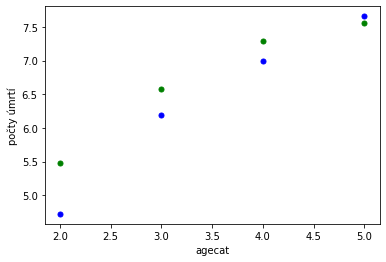

In [ ]:
y_scaled = data_poiss["deaths"]/data_poiss["person_years"]*100000
plt.plot(agecat[1:5], np.log(y_scaled)[1:5], 'go', markersize=5)
plt.plot(agecat[6:10], np.log(y_scaled)[6:10], 'bo', markersize=5)
plt.xlabel('agecat')
plt.ylabel('počty úmrtí')

Je jasně vidět, že vztah není lineární, přidáme do modelu proměnnou `agecat^2`

## Model s kvadratickou závislostí na věku - Model 0  

In [ ]:
agecat_2 = np.power(agecat, 2)
mdl_0 = smf.glm('deaths ~ smoke + agecat + agecat_2', data=data_poiss, offset=np.log(data_poiss['person_years']), family=sm.families.Poisson(link=sm.families.links.log)).fit()
print(mdl_0.summary())
mdl_0.pvalues[2]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                   10
Model:                            GLM   Df Residuals:                        6
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33.622
Date:                Sat, 14 May 2022   Deviance:                       12.176
Time:                        13:46:40   Pearson chi2:                     11.2
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.8340      0.295    -33.317      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


6.528149778755597e-31

Všechny regresory jsou v modelu významné a hodnota deviační statistiky klesla na 12.176, porovnejme ji s kritickou hodnotou LRT testu

In [ ]:
from numpy.core.numeric import ones
# matice modelu udělaná ručně
intercept = ones(10)
data_poiss_2 = data_poiss.assign(agecat = agecat, agecat_2 = agecat_2, intercept = intercept)
X_m = data_poiss_2[['intercept', 'smoke', 'agecat', 'agecat_2']].values.astype(np.float)
print(X_m)
n, p = X_m.shape
print(n)
print(p)

[[ 1.  1.  1.  1.]
 [ 1.  1.  2.  4.]
 [ 1.  1.  3.  9.]
 [ 1.  1.  4. 16.]
 [ 1.  1.  5. 25.]
 [ 1.  0.  1.  1.]
 [ 1.  0.  2.  4.]
 [ 1.  0.  3.  9.]
 [ 1.  0.  4. 16.]
 [ 1.  0.  5. 25.]]
10
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
# kritická hodnota in R:
print(f'quantile corresponding to the lower tail probability q: {stats.chi2.ppf(1-0.05, n-p)}')

# p-hodnota testu 
p_2 = stats.chi2.cdf(mdl_0.deviance, n-p)
p_val = 1 - p_2
print(f'p hodnota testu: {p_val}')


quantile corresponding to the lower tail probability q: 12.591587243743977
p hodnota testu: 0.05816524586351579


Hypotézu, že model dobře popisuje data jsme na hladině významnosti 5% těsně nezamítli. Zkusíme ještě přidat do modelu interakci (na obrázku z přednášky byla vidět možná změna závislosti na kouření s rostoucím věkem)

## Model s kvadratickou závislostí na věku a interakcí - Model 1 

In [ ]:
mdl_1 = smf.glm('deaths ~ smoke + agecat + agecat_2 + smoke:agecat', data=data_poiss, offset=np.log(data_poiss['person_years']), family=sm.families.Poisson(link=sm.families.links.log)).fit()
print(mdl_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                   10
Model:                            GLM   Df Residuals:                        5
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.352
Date:                Sat, 14 May 2022   Deviance:                       1.6354
Time:                        13:46:57   Pearson chi2:                     1.55
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.7918      0.45

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


Všechny proměnné jsou v modelu významné a hodnota deviační statsitiky klesla na hodnotu 1.6354. Zkuste vypočítat LRT:

a hypotézu vhodnosti modelu tedy nezamítáme s p-hodnotou 0.897. To indikuje, že model dobře popisuje data.

Pro ilustraci ještě spočtěme hodnotu deviační statistiky pomocí vzorce z přednášky

LRT Test for Poiison regression by Deviance sttistics:
$$S = 2\sum_{i=1}^n \left[ y_i (ln(\frac{y_i}{s_i}) - x_i^T \hat{\beta}) - s_i (\frac{y_i}{s_i} - e^{x_i^T \hat{\beta}}) )\right] = 2\sum_{i=1}^n \left[ y_i ln(\frac{y_i}{\hat{\mu_i}}) - (y_i - \hat{\mu_i})\right]
$$

In [ ]:
print(mdl_1.deviance)
print(mdl_0.deviance - mdl_1.deviance)
dev = mdl_0.deviance - mdl_1.deviance

1.6353701314643632
10.540175177950632


pro kritickou hodnotu testu platí 

In [ ]:
# kritická hodnota in R:
print(f'quantile corresponding to the lower tail probability q: {stats.chi2.ppf(1-0.05, 1)}')

# p-hodnota testu 
p_2 = stats.chi2.cdf(dev, 1)
p_val = 1 - p_2
print(f'p hodnota testu: {p_val}')

quantile corresponding to the lower tail probability q: 3.841458820694124
p hodnota testu: 0.0011680734811497784


interakce je tedy v modelu významná. Případně můžeme použít přímo funkci `anova()`

In [ ]:
def anova(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    print(f'Deviance: {f_stat}')
    print(f'P-value: {p_value}')
    return (f_stat, p_value)

A = anova(mdl_0, mdl_1)

Deviance: 10.540175177950632
P-value: 0.017541789764504982


která vrací stejný výsledek.


## Analýza Modelu 1

Scatterplot pro pozorované a predikované hodnoty vysvětlované proměnné

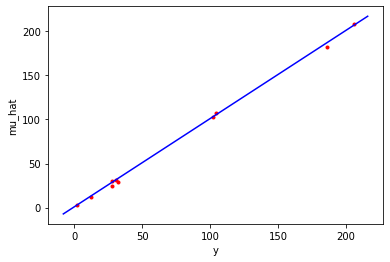

In [ ]:
y = data_poiss["deaths"]
plt.plot(y, mdl_1.mu, 'r.')
plt.xlabel('y')
plt.ylabel('mu_hat')
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'b-')

abline(1,1)

Pozorované a predikované hodnoty velmi dobře odpovídají.

**Obrázky reziduí**

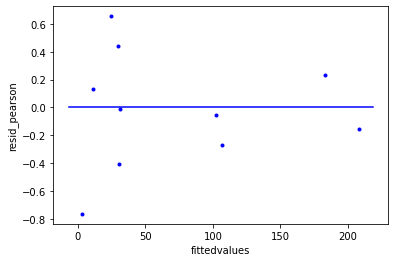

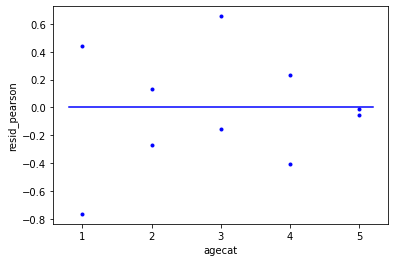

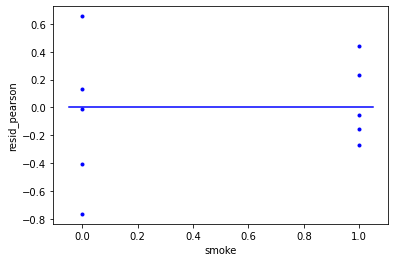

In [ ]:
# rezidua vs. fitted values
plt.plot(mdl_1.fittedvalues, mdl_1.resid_pearson, 'b.')
abline(0,0)
plt.xlabel('fittedvalues')
plt.ylabel('resid_pearson')
plt.show()
# rezizua vs. agecat
plt.plot(agecat,mdl_1.resid_pearson, 'b.')
abline(0,0)
plt.xlabel('agecat')
plt.ylabel('resid_pearson')
plt.show()
# rezizua vs. smoke
plt.plot(data_poiss["smoke"], mdl_1.resid_pearson,'b.')
abline(0,0)
plt.xlabel('smoke')
plt.ylabel('resid_pearson')

plt.show()

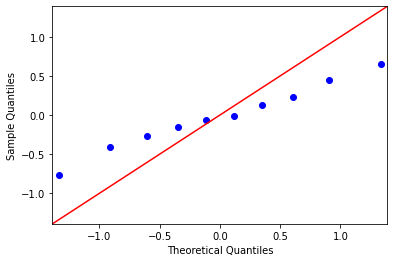

In [ ]:
f = sm.qqplot(mdl_1.resid_pearson, line ='45')
plt.show(f)

vzhledem k mlému počtu pozorování zde není vidět žádný zásadní problé. Otestujme ještě formálně normalitu rezidí

In [ ]:
shapiro_test = stats.shapiro(mdl_1.resid_pearson)
print(f'statistika testu: {shapiro_test[0]}')
print(f'p-hodnota testu: {shapiro_test[1]}')


statistika testu: 0.9942744374275208
p-hodnota testu: 0.9996621012687683


Hypotéza normality není zamítnuta.

**Influenční pozorování a pákové body**

(array([0.1500298 , 0.02139909, 0.01357645, 0.01610304, 0.0143573 ,
       0.06770068, 0.00392443, 0.08240022, 0.02560098, 0.00033956]), array([0.97115297, 0.99966257, 0.99988881, 0.99983115, 0.99987248,
       0.99486907, 0.99999483, 0.99201132, 0.99947943, 0.99999999]))


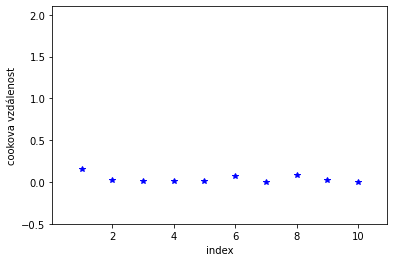

In [ ]:
from pandas.core.indexes.base import Index
from pandas._libs import index
#create instance of influence
influence = mdl_1.get_influence()
#obtain Cook's distance for each observation
cooks = influence.cooks_distance
#display Cook's distances
print(cooks)
index = list(range(1, np.shape(cooks)[1]+1))

plt.plot(index, cooks[0][0:10], 'b*')
plt.xlabel('index')
plt.ylabel('cookova vzdálenost')
plt.ylim((-0.5,2.1))
abline(8/(n-2*p),0) 
plt.show()

In [ ]:
# in R (?)
# lev <- hatvalues(mdl_1)       # diag. prvky projekční matice
# plot(lev,col="red", cex=1.3, lwd=2, ylim = c(0,1.2))
# abline(2*p/n,0)

Ani v jednom případě nevidíme podezřele velké hodnoty

## Interpretace parametrů

Spočteme relativní rizika v Modelu 1

In [ ]:
par_est_1 = mdl_1.params
print(par_est_1)
RR_1 = np.exp(par_est_1)
print(RR_1)

Intercept           -10.791763
smoke[T.1]            1.440972
agecat                2.376478
smoke[T.1]:agecat    -0.307548
agecat_2             -0.197677
dtype: float64
Intercept             0.000021
smoke[T.1]            4.224800
agecat               10.766918
smoke[T.1]:agecat     0.735248
agecat_2              0.820635
dtype: float64


Diskuze obdržených hodnot a výpočet relativních rizik pro jednotlivé kategorie věku jsou v Sekci 7.7 materiálů k přednášce.

Pro Model 0 bez interakcí je situace jednodušší a lze snado získat odhady RR a příslušné intervaly spolehlivosti

In [ ]:
print(np.exp(mdl_0.params))
print(np.exp(mdl_0.conf_int()))

Intercept     0.000054
smoke[T.1]    1.425497
agecat        8.123048
agecat_2      0.823345
dtype: float64
                   0          1
Intercept   0.000030   0.000096
smoke[T.1]  1.154970   1.759389
agecat      5.694903  11.586485
agecat_2    0.780673   0.868348


### Task: 
* Try to model with and without offset. Compare results, why to use/ not use offset?
* Try Poisson distribution with factor variables (contingency tables approach).

